In [10]:
import numpy as np
import random
import copy
import time
import os, psutil
SIZE=5
GAMMA=0.85
ALL_ACTIONS= ('U', 'D', 'L', 'R','X')
positions=()
board=()
jean=(4,1) #Initial position of jean 
magneto=() 
wolve=() 
m_not_allow=(4,4) #magneto can't move to pos 5,5, ie (4,4) intex
blocked=(3,2) #blocked position due to wall

def give_actions(i,j,player): #it will return the valid actions of the particular player(using for wolve only)
    global SIZE
    flag=[1]*4 #U
    if (i-1==blocked[0] and j==blocked[1]) or i-1<0 or (i-1,j)==player:
        flag[0]=0 #U
    if (i+1==blocked[0] and j==blocked[1]) or i+1>=SIZE or (i+1,j)==player:
        flag[1]=0 #D
    if (j-1==blocked[1] and i==blocked[0]) or j-1<0 or (i,j-1)==player:
        flag[2]=0 #L
    if (j+1==blocked[1] and i==blocked[0]) or j+1>=SIZE or (i,j)==player:
        flag[3]=0 #R
    temp=[]
    if flag[0]==1:
        temp.append('U')
    if flag[1]==1:
        temp.append('D')
    if flag[2]==1:
        temp.append('L')
    if flag[3]==1:
        temp.append('R')
#     if any(flag):
    temp.append('X') #appending the no move condition
    return tuple(temp)

def make_move(z,action): #will update cordinates w.r.t to action
    if action == 'U':
        z[0] -= 1
    elif action == 'D':
        z[0] += 1
    elif action == 'R':
        z[1] += 1
    elif action == 'L':
        z[1] -= 1
    return tuple(z)

def manhattan(a,b):
    return (abs(a[0]-b[0])+abs(a[1]-b[1]))

def move_jean_magnato():
    global magneto,jean,wolve
    if random.random()<=0.20:  #jean remain at its position 80% of time
        if jean==(0,4):
            jean=(4,1)
        else:
            jean=(0,4)
            
    z=copy.deepcopy(magneto)
    if random.random()<=0.95: #probability to move to other position
        for i in range(50): #we need a valid value (not (4,4)) for the magneto
            valid_moves=give_actions(magneto[0],magneto[1],wolve)
            
            ###MOVE SELECTIONS ###
            best=[]
            for action in valid_moves:
               best.append( manhattan(make_move(list(magneto),action),wolve))
            
            index=best.index(min(best))
            next_move=valid_moves[index]
            z=make_move(list(z),next_move)
            if z==m_not_allow:  #magneto can't move to index (4,4) ie location 5,5
                continue
            break
    magneto=z
    
class Grid: #SIZE x SIZE grid object
  def __init__(self,size,loc):
    self.size=size
    self.x =loc[0]
    self.y=loc[1]   #updating the starting position x,y coordinates

  def set(self,rewards,actions):
    self.rewards=rewards  #setting the rewards of the object
    self.actions=actions #setting the actions of the object

  def current_state(self): #return the current state of the object (wolve)
    return (self.x, self.y)

  def set_state(self,state):
    self.x=state[0]
    self.y=state[1]
    global wolve
    wolve=(self.x,self.y) #updating the latest wolve. position

  def move(self, act):  #will update coordinates
    if random.random()<=0.05: #%% of the time, it don't move at all
        return self.rewards.get((self.x,self.y),0)
    if act in self.actions[(self.x, self.y)]:
      if act=='U': #UP
        self.x-=1
      elif act=='D': #DOWN
        self.x+=1
      elif act=='R': #RIGHT
        self.y+=1
      elif act=='L': #LEFT
        self.y-=1
    #if 'X' found, no update to the x and y coordinates
    return self.rewards.get((self.x,self.y),0)

  def all_states(self):
    return  set(self.rewards.keys())| set(self.actions.keys())

def standard_grid():
  global ALL_ACTIONS,blocked,wolve,SIZE,magneto,jean
  n=SIZE
  for i in range(200): #will try to generate the valid non intersecting positions FOR MAGNETO wolve during 
                        #initialization of the board
        magneto=(random.randint(0,n-1),random.randint(0,n-1))  #random position for magneto
        wolve=(random.randint(0,n-1),random.randint(0,n-1))   #random position for wolve
        if magneto==wolve or magneto==blocked or wolve==blocked or wolve==jean or magneto==jean or magneto==m_not_allow:
            continue   #if not valid position for wolve and magneto, continue
        break
  g_obj= Grid(SIZE,wolve)  #creating the object
  rewards = {}
  actions={}
  for i in range(SIZE):
        for j in range(SIZE):
            if (i,j)==blocked: # or (i,j)==jean or (i,j)==magneto:
                continue
            act='X'
            if random.random()<=0.95: #95% of time it will move to different position
                act=give_actions(i,j,magneto)
            actions[(i,j)]=act #updating the actions
  g_obj.set(rewards, actions)  #updating actions (all actions added)
  return g_obj #returning object


def create_grid(default_cost=0.0):  #default cost (reward) of all position is 0
  g_obj = standard_grid()
  t_rwd={} #temp rewards
  for i in range(SIZE):
        for j in range(SIZE):
            t_rwd[(i,j)]=default_cost
            
  ##updating the rewards w.r.t jean, magneto and wolve
  t_rwd[jean]=20
  t_rwd[magneto]=-20
  if jean==magneto and magneto==wolve:
    t_rwd[magneto]=-15
  g_obj.rewards.update(t_rwd)
  return g_obj

def print_values(Val, grid):
  for i in range(grid.size):
    print("-----------------------------------")
    for j in range(grid.size):
      value = Val.get((i,j), 0)
      if value >= 0:
        print(" %.2f|" % value, end="")
      else:
        print("%.2f|" % value, end="")
    print()


def print_policy(Pol, grid):
  for i in range(grid.size):
    print("-------------------------------")
    for j in range(grid.size):
      action = Pol.get((i,j), ' ')
      print("  %s  |" % action, end="")
    print()

In [11]:
grid = create_grid()
print("Initial rewards configurations:")
print_values(grid.rewards, grid)

Initial rewards configurations:
-----------------------------------
 0.00| 0.00| 0.00| 0.00| 0.00|
-----------------------------------
 0.00| 0.00| 0.00| 0.00| 0.00|
-----------------------------------
 0.00| 0.00|-20.00| 0.00| 0.00|
-----------------------------------
 0.00| 0.00| 0.00| 0.00| 0.00|
-----------------------------------
 0.00| 20.00| 0.00| 0.00| 0.00|


In [12]:
policy ={} #policy
for st in grid.actions.keys():
  policy[st]=np.random.choice(ALL_ACTIONS) #updating the policies (choosing randomly) for wolve

In [13]:
print("Initial random policy")
print_policy(policy, grid)

Initial random policy
-------------------------------
  U  |  R  |  D  |  U  |  L  |
-------------------------------
  X  |  U  |  X  |  L  |  X  |
-------------------------------
  R  |  U  |  U  |  D  |  R  |
-------------------------------
  L  |  X  |     |  R  |  U  |
-------------------------------
  L  |  R  |  D  |  X  |  X  |


In [14]:
#print(grid.all_states())

In [15]:
Val = {} #value 
states=grid.all_states()
for st in states:
  if st in grid.actions:
    Val[st] = np.random.random()  #randomly initializing the values
  else:
    Val[st] = 0   #blocked wall will be having zero probability
print("Initial random probability")
print_values(Val, grid)

Initial random probability
-----------------------------------
 0.27| 0.93| 0.55| 0.80| 0.94|
-----------------------------------
 0.21| 0.17| 0.80| 0.47| 0.23|
-----------------------------------
 0.89| 0.10| 0.54| 0.86| 0.14|
-----------------------------------
 0.43| 1.00| 0.00| 0.48| 0.08|
-----------------------------------
 0.74| 0.89| 0.58| 0.74| 0.54|


In [16]:
#print("wolve",wolve,"Magnaton",magneto,"Jeane",jean)

In [17]:
start_time=time.time()
iter=0
delt=[]
for _ in range(1000):
  iter+=1
#   print()
#   print("Values %d: " % iter)
#   print_values(Val, grid)
#   print()
#   print("Policy %d: " % iter)
#   print_policy(policy, grid)

  delta_change=0
  for st in states:
    
    old_val = Val[st]
    if st!=blocked:   #we are not calculating policy for wall
        old_pol= policy[st]
    new_pol=None
    
    if st in policy:
      new_val = float('-inf')
    
      for a in give_actions(st[0],st[1],magneto):   #checking particular state agains it's its best actions
        grid.set_state(st)
        #V[jean]=0
        r = grid.move(a) 
        
        c=grid.current_state()
        if c==jean or c==magneto:    #if current state is jean or magneto, then v will not change
            v=r
        else:
            v = r + GAMMA * Val[c]
            
        if v > new_val:
          new_val = v
          new_pol = a

      ########MOVING THE MAGNATO AND JEAN AND UPDATING THE REWARDS FOR WOLVE (for same state) ###
      grid.rewards[jean]=0
      grid.rewards[magneto]=0
        
      move_jean_magnato()      #it will move both jean and magnato to their respective new positions
        
      grid.rewards[jean]=20
      grid.rewards[magneto]=-20
      if jean==magneto and wolve==jean:
         grid.rewards[jean]=-15
            
      ###### NOTE:-- BOTH value and policy update merged and calculated in the same loop #####
      Val[st] = new_val        ########VALUE UPDATE
      if new_pol!=None and st!=blocked:
          policy[st]=new_pol   #########POLICY UPDATE
      delta_change = max(delta_change, np.abs(old_val - Val[st]))
    
  delt.append(delta_change)
  if delta_change < 0.001:
    break
print("Total time:",time.time()-start_time)
process = psutil.Process(os.getpid())
print("Memory usage:",process.memory_info().rss/(1024*1024),"MB")

Total time: 1.1477773189544678
Memory usage: 71.57421875 MB


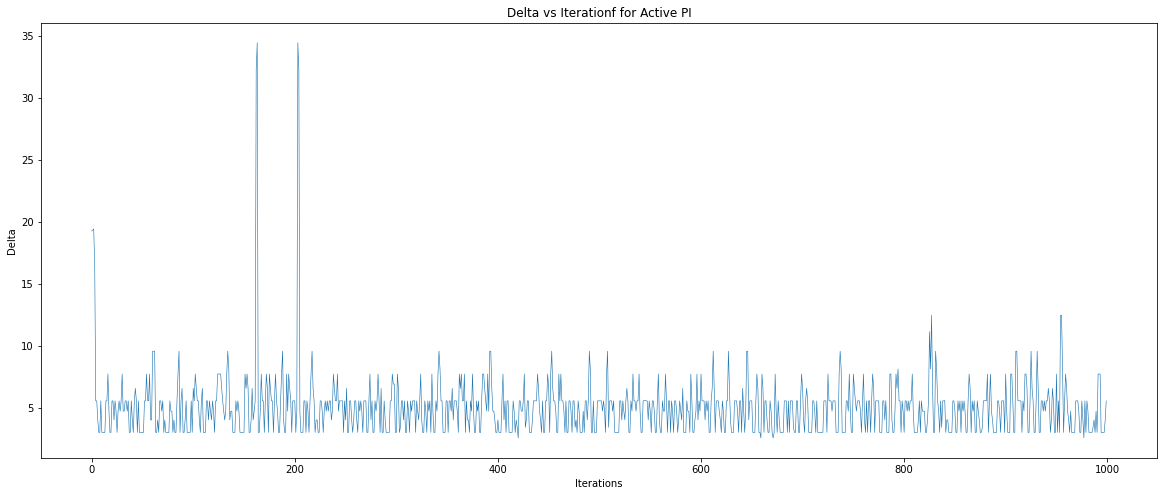

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,8.0]
plt.plot([i for i in range(len(delt))],delt,linewidth=0.6)
plt.xlabel("Iterations")
plt.ylabel("Delta")
plt.title("Delta vs Iterationf for Active PI")
# plt.savefig("active_pi")
plt.show()